In [1]:
import matplotlib.pyplot as plt
import numpy as np

from hazma.vector_mediator import VectorMediator, KineticMixing, QuarksOnly
from hazma.scalar_mediator import ScalarMediator

from utilities import get_color, get_tex_label, latex_text_width_1col

## Branching fractions as a function of $m_\chi$

### 6 panels

In [ ]:
mxs = np.logspace(np.log10(50), np.log10(250), 500)
mM_light = 200.
mM_heavy = 1000.
mMs = [mM_light, mM_heavy]
vx = 1e-6

vms = np.array([[KineticMixing(100, mM, gvxx=1., eps=1e-1)
                 for mM in mMs],
                [QuarksOnly(100, mM, gvxx=1., gvuu=1., gvdd=-1., gvss=0.)
                 for mM in mMs],
                [QuarksOnly(100, mM, gvxx=1., gvuu=1., gvdd=1., gvss=0.)
                 for mM in mMs]])
bfs = []

for row in range(3):
    bfs_temp = []
    
    for col in range(2):
        # Computes BRs for each DM mass
        bfs_raw = []
        for mx in mxs:
            vms[row, col].mx = mx
            e_cm = 2. * mx * (1 + 0.5 * vx**2)
            
            bfs_raw.append(vms[row, col].annihilation_branching_fractions(e_cm))
            
        # Convert the list of dicts into a dict of lists
        bfs_temp.append({fs: np.array([bf[fs] for bf in bfs_raw])
                         for fs in VectorMediator.list_annihilation_final_states()})

    bfs.append(bfs_temp)
    
bfs = np.array(bfs)

# Old

## Branching fractions as a function of $g_{Vuu}$ and $g_{Vdd}$

First, create an array with 500 linearly spaces values of $g_{Vdd}/g_{Vuu}$ to scan over:

In [2]:
ratio_min, ratio_max, n_ratios = -3, 3, 500
ratios = np.linspace(ratio_min, ratio_max, n_ratios)

Next, initialize the vector mediator class. We set all ancillary couplings to zero; we will soon change $g_{Vdd}$ in our scan. We take $m_\chi = 250$ MeV, the upper limit of validity for this model. The final plot below changes little with $m_\chi$; the primary changes are that the $\pi^+ \pi^- \pi^0$ channel shuts off below $m_\chi \approx 210$ MeV and the narrow region around $g_{Vuu} = g_{Vdd}$ where the $\pi^+ \pi^-$ channel becomes inaccessible broadens slightly.

In [3]:
vm_args = {"mx": 250., "mv": 1000., "gvxx": 1., "gvuu": 1., "gvdd": 1.,
           "gvss": 0., "gvee": 0., "gvmumu": 0.}
vm = VectorMediator(**vm_args)

Now we compute the branching fractions for each value of $g_{Vdd} / g_{Vuu}$. To avoid dividing by zero, it's necessary to give the DM a small amount of kinetic energy by setting its velocity equal to the usual $10^{-3}c$. We store the dictionaries returned by `branching_fractions()` in the list `bfs_raw`.

In [4]:
vx_mw = 1.0e-3  # approximate DM velocity in Milky Way halo

bfs_varying_gs = {}

# Compute branching fractions for different couplings
bfs_raw = []
for ratio in ratios:
    vm.gvdd = vm.gvuu * ratio
    bfs_raw.append(vm.branching_fractions(2. * vm.mx * (1. + 0.5 * vx_mw)))

This turns our list of dictionaries of branching fractions into a dictionary of lists of branching fractions:

In [5]:
bfs = {fs: [bf[fs] for bf in bfs_raw] for fs in vm.list_final_states()}

Finally, we iterate over the final states to which $V$ has nonzero couplings and plot their branching fractions. The branching fractions for the different final states are equal to zero for a certain ratio of the couplings:

* $\pi^+ \pi^-$: $g_{Vuu} = g_{Vdd}$
* $\pi^+ \pi^- \pi^0$: $g_{Vuu} = -g_{Vdd}$
* $\pi^0 \gamma$: $g_{Vuu} = -\frac{1}{2}g_{Vdd}$

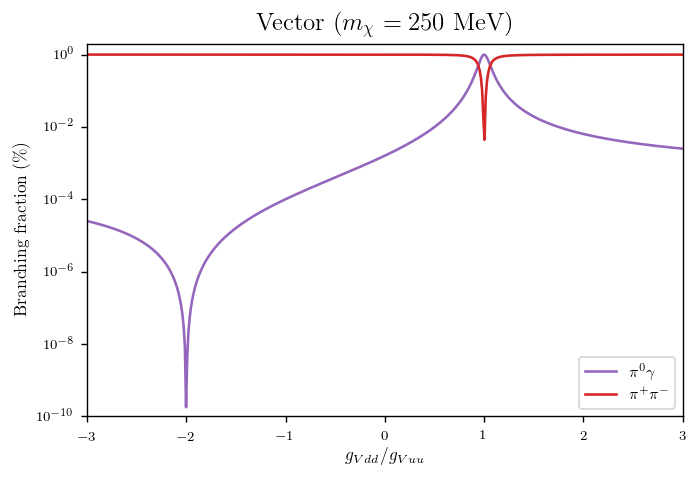

In [17]:
plt.figure(figsize=(latex_text_width_1col, 4))

for fs, bf_list in bfs.iteritems():
    if fs not in ["e e", "mu mu", "v v"]:
        plt.plot(ratios, bf_list, color=get_color(fs), label=get_tex_label(fs))

plt.yscale("log")
plt.title("Vector ($m_\chi = 250$ MeV)")
plt.xlabel(r"$g_{Vdd} / g_{Vuu}$")
plt.ylabel("Branching fraction (\%)")
plt.legend()
plt.xlim(ratios[[0, -1]])
plt.ylim(1e-10, 2)

plt.tight_layout()
plt.savefig("figures/vector_branching_fractions.pdf")

## Francesco's suggestions

### Decay branching fractions

#### Quark couplings only

##### Mediator decay

In [19]:
coupling_list = [{"gvuu": 1., "gvdd": 0.},
                 {"gvuu": 1., "gvdd": 1.},
                 {"gvuu": 0., "gvdd": 1.},
                 {"gvuu": 1., "gvdd": -1.}]

vm = VectorMediator(mx=200., mv=1000., gvxx=1., gvuu=1., gvdd=0.,
                    gvss=0., gvee=0., gvmumu=0.)

v_decay_fss = (set(vm.list_final_states()) - set(['v v'])) | set(['x x'])

mvs = np.logspace(np.log10(140), np.log10(500), 500)

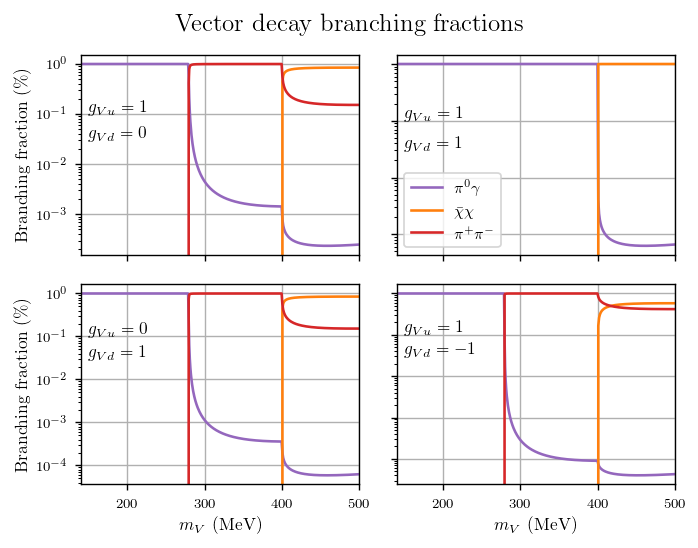

In [20]:
plt.figure(figsize=(latex_text_width_1col, 0.8*latex_text_width_1col))

for i, couplings in enumerate(coupling_list):
    plt.subplot(2, 2, i+1)
    gvuu = couplings["gvuu"]
    gvdd = couplings["gvdd"]
    
    vm.gvuu = gvuu
    vm.gvdd = gvdd
    
    # Get branching fractions
    bfs_raw = []
    for mv in mvs:
        vm.mv = mv
        bfs_raw.append(vm.partial_widths())

    bfs = {fs: [bf[fs] / bf["total"] for bf in bfs_raw] for fs in v_decay_fss}
    
    for fs, bf_list in bfs.iteritems():
        if fs in ["pi0 g", "pi pi", "x x"]:
            plt.plot(mvs, bf_list, color=get_color(fs), label=get_tex_label(fs))
        
    plt.xlim(mvs[[0, -1]])
    plt.yscale("log")
    plt.text(150, 1e-1, r"$g_{Vu} = %i$" % gvuu, fontsize=10)
    plt.text(150, 3e-2, r"$g_{Vd} = %i$" % gvdd, fontsize=10)
    plt.grid()
    
    if i == 1:
        plt.legend()
    if i in [1, 3]:
        plt.tick_params(labelleft="off")
    if i in [0, 2]:
        plt.ylabel("Branching fraction (\%)")
    if i in [0, 1]:
        plt.tick_params(labelbottom="off")
    if i in [2, 3]:
        plt.xlabel(r"$m_V$ (MeV)")
        
plt.suptitle("Vector decay branching fractions")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("figures/vector_decay_branching_fractions.pdf")

##### DM annihilation

In [21]:
coupling_list = [{"gvuu": 1., "gvdd": 0.},
                 {"gvuu": 1., "gvdd": 1.},
                 {"gvuu": 0., "gvdd": 1.},
                 {"gvuu": 1., "gvdd": -1.}]

vm = VectorMediator(mx=200., mv=200., gvxx=1., gvuu=1., gvdd=0.,
                    gvss=0., gvee=0., gvmumu=0.)

vx_mw = 1e-3
mxs = np.logspace(np.log10(70), np.log10(250), 500)

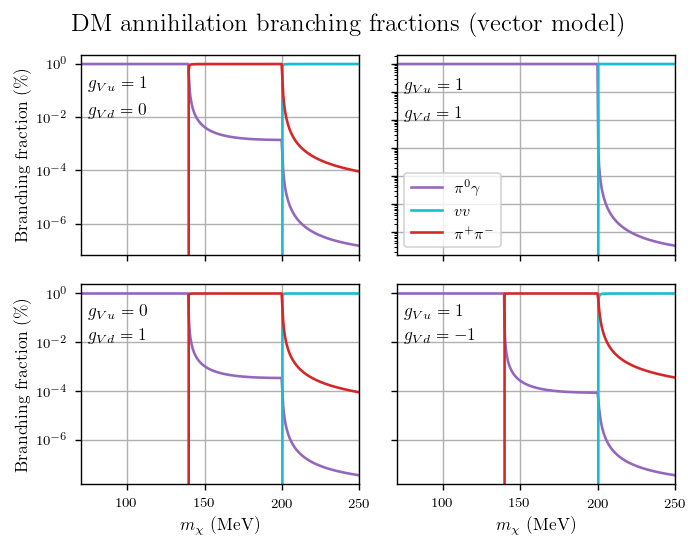

In [22]:
plt.figure(figsize=(latex_text_width_1col, 0.8*latex_text_width_1col))

for i, couplings in enumerate(coupling_list):
    plt.subplot(2, 2, i+1)
    gvuu = couplings["gvuu"]
    gvdd = couplings["gvdd"]
    
    vm.gvuu = gvuu
    vm.gvdd = gvdd
    
    # Get branching fractions
    bfs_raw = []
    for mx in mxs:
        vm.mx = mx
        e_cm = 2. * vm.mx * (1. + 0.5 * vx_mw)
        bfs_raw.append(vm.branching_fractions(e_cm))

    bfs = {fs: [bf[fs] for bf in bfs_raw] for fs in vm.list_final_states()}
    
    for fs, bf_list in bfs.iteritems():
        if fs in ["pi0 g", "pi pi", "v v"]:
            plt.plot(mxs, bf_list, color=get_color(fs), label=get_tex_label(fs))
        
    plt.xlim(mxs[[0, -1]])
    plt.yscale("log")
    plt.text(75, 1e-1, r"$g_{Vu} = %i$" % gvuu, fontsize=10)
    plt.text(75, 1e-2, r"$g_{Vd} = %i$" % gvdd, fontsize=10)
    plt.grid()
    
    if i == 1:
        plt.legend()
    if i in [1, 3]:
        plt.tick_params(labelleft="off")
    if i in [0, 2]:
        plt.ylabel("Branching fraction (\%)")
    if i in [0, 1]:
        plt.tick_params(labelbottom="off")
    if i in [2, 3]:
        plt.xlabel(r"$m_\chi$ (MeV)")
        
plt.suptitle("DM annihilation branching fractions (vector model)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("figures/vector_dm_ann_branching_fractions_quarks_only.pdf")

#### Kinetic mixing

##### Mediator decay

In [12]:
eps_list = [0.1, 0.01, 0.001, 0.0001]
v_decay_fss = (set(vm.list_final_states()) - set(['v v'])) | set(['x x'])
mvs = np.logspace(np.log10(140), np.log10(500), 500)

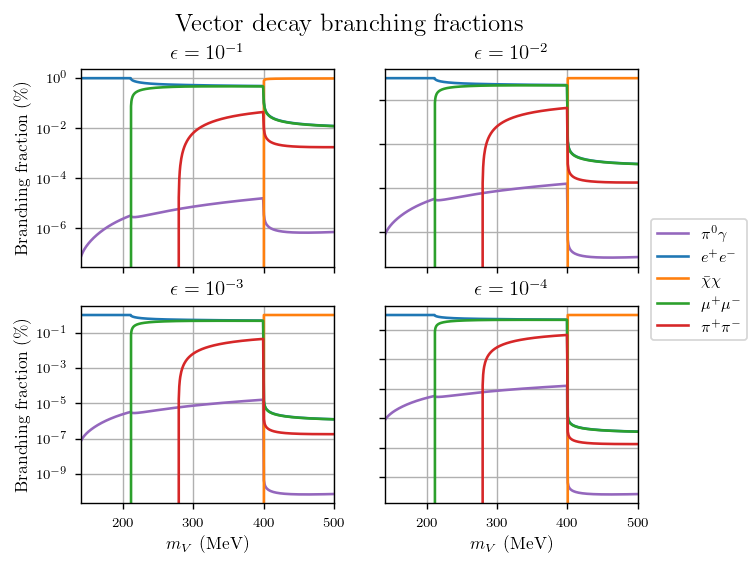

In [16]:
plt.figure(figsize=(latex_text_width_1col, 0.8*latex_text_width_1col))

for i, eps in enumerate(eps_list):
    plt.subplot(2, 2, i+1)

    vm = VectorMediator(mx=200., mv=1000., gvxx=1., gvuu=2*eps / 3,
                        gvdd=-eps / 3, gvss=-eps / 3, gvee=-eps, gvmumu=-eps)
    
    # Get branching fractions
    bfs_raw = []
    for mv in mvs:
        vm.mv = mv
        bfs_raw.append(vm.partial_widths())

    bfs = {fs: [bf[fs] / bf["total"] for bf in bfs_raw] for fs in v_decay_fss}
    
    for fs, bf_list in bfs.iteritems():
        lab = get_tex_label(fs) if i == 0 else None
        plt.plot(mvs, bf_list, color=get_color(fs), label=lab)
        
    plt.xlim(mvs[[0, -1]])
    plt.yscale("log")
    plt.title(r"$\epsilon = 10^{%i}$" % np.log10(eps), fontsize=12)
    plt.grid()

    if i in [1, 3]:
        plt.tick_params(labelleft="off")
    if i in [0, 2]:
        plt.ylabel("Branching fraction (\%)")
    if i in [0, 1]:
        plt.tick_params(labelbottom="off")
    if i in [2, 3]:
        plt.xlabel(r"$m_V$ (MeV)")

lgd = plt.figlegend(loc='center right', bbox_to_anchor=(1.05, 0.5))
title = plt.suptitle("Vector decay branching fractions")

plt.savefig("figures/vector_decay_branching_fractions_kinetic_mixing.pdf",
            bbox_extra_artists=(lgd, title), bbox_inches='tight')

##### DM annihilation

In [8]:
eps_list = [0.1, 0.01, 0.001, 0.0001]
vx_mw = 1e-3
mxs = np.logspace(np.log10(70), np.log10(250), 500)

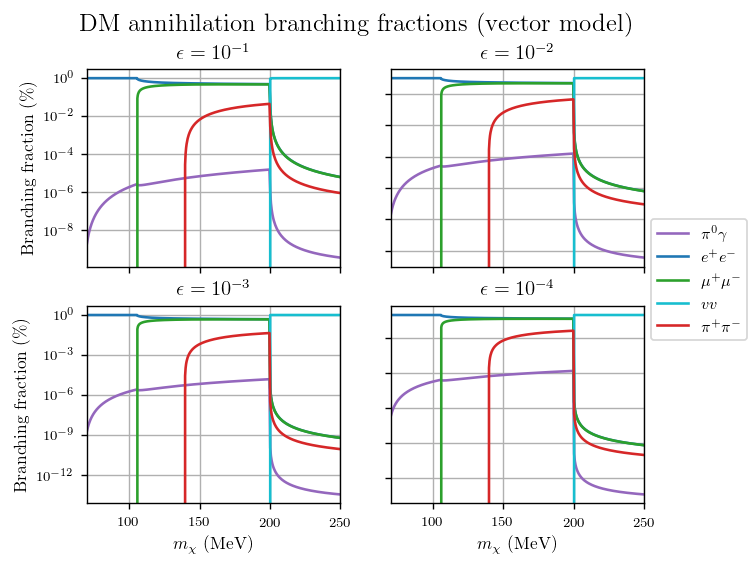

In [15]:
plt.figure(figsize=(latex_text_width_1col, 0.8*latex_text_width_1col))

for i, eps in enumerate(eps_list):
    plt.subplot(2, 2, i+1)

    vm = VectorMediator(mx=200., mv=200., gvxx=1., gvuu=2*eps / 3,
                        gvdd=-eps / 3, gvss=-eps / 3, gvee=-eps, gvmumu=-eps)
    
    # Get branching fractions
    bfs_raw = []
    for mx in mxs:
        vm.mx = mx
        e_cm = 2. * vm.mx * (1. + 0.5 * vx_mw)
        bfs_raw.append(vm.branching_fractions(e_cm))

    bfs = {fs: [bf[fs] for bf in bfs_raw] for fs in vm.list_final_states()}
    
    for fs, bf_list in bfs.iteritems():
        lab = get_tex_label(fs) if i == 0 else None
        plt.plot(mxs, bf_list, color=get_color(fs), label=lab)
        
    plt.xlim(mxs[[0, -1]])
    plt.yscale("log")
    plt.title(r"$\epsilon = 10^{%i}$" % np.log10(eps), fontsize=12)
    plt.grid()

    if i in [1, 3]:
        plt.tick_params(labelleft="off")
    if i in [0, 2]:
        plt.ylabel("Branching fraction (\%)")
    if i in [0, 1]:
        plt.tick_params(labelbottom="off")
    if i in [2, 3]:
        plt.xlabel(r"$m_\chi$ (MeV)")

lgd = plt.figlegend(loc='center right', bbox_to_anchor=(1.05, 0.5))
title = plt.suptitle("DM annihilation branching fractions (vector model)")

plt.savefig("figures/vector_dm_ann_branching_fractions_kinetic_mixing.pdf",
            bbox_extra_artists=(lgd, title), bbox_inches='tight')

### Annihilation branching fractions

In [36]:
coupling_list = [{"gvuu": 1., "gvdd": 0.},
                 {"gvuu": 1., "gvdd": 1.},
                 {"gvuu": 0., "gvdd": 1.},
                 {"gvuu": 1., "gvdd": -1.}]

vx_mw = 1.0e-3  # approximate DM velocity in Milky Way halo

vm = VectorMediator(mx=200., mv=200., gvxx=1., gvuu=1., gvdd=0.,
                    gvss=0., gvee=0., gvmumu=0.)

v_decay_fss = (set(vm.list_final_states()) - set(['v v'])) | set(['x x'])

mxs = np.logspace(np.log10(140), np.log10(250), 500)

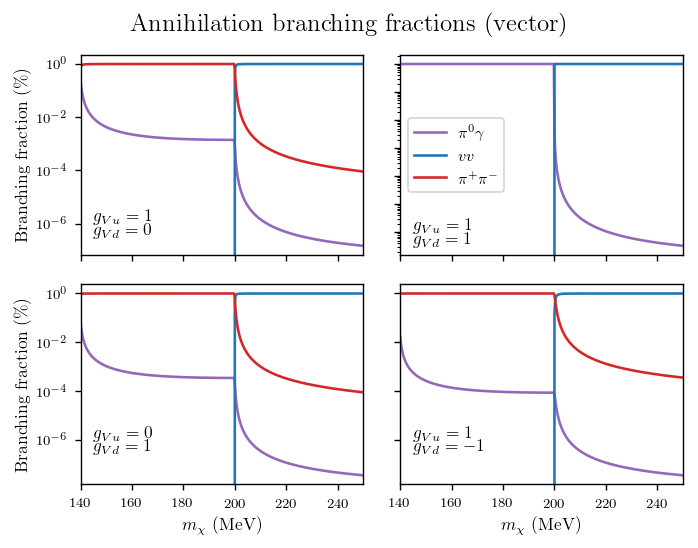

In [41]:
plt.figure(figsize=(latex_text_width_1col, 0.8*latex_text_width_1col))

for i, couplings in enumerate(coupling_list):
    plt.subplot(2, 2, i+1)
    gvuu = couplings["gvuu"]
    gvdd = couplings["gvdd"]
    
    vm.gvuu = gvuu
    vm.gvdd = gvdd
    
    # Get branching fractions
    bfs_raw = []
    for mx in mxs:
        vm.mx = mx
        bfs_raw.append(vm.branching_fractions(2. * vm.mx * (1. + 0.5 * vx_mw)))

    bfs = {fs: [bf[fs] for bf in bfs_raw] for fs in vm.list_final_states()}
    
    for fs, bf_list in bfs.iteritems():
        if fs in ["pi0 g", "pi pi", "v v"]:
            plt.plot(mxs, bf_list, color=get_color(fs), label=get_tex_label(fs))
        
    plt.xlim(mxs[[0, -1]])
    plt.yscale("log")
    plt.text(145, 1e-6, r"$g_{Vu} = %i$" % gvuu, fontsize=10)
    plt.text(145, 3e-7, r"$g_{Vd} = %i$" % gvdd, fontsize=10)
    
    if i == 1:
        plt.legend(loc="center left")
    if i in [1, 3]:
        plt.tick_params(labelleft="off")
    if i in [0, 2]:
        plt.ylabel("Branching fraction (\%)")
    if i in [0, 1]:
        plt.tick_params(labelbottom="off")
    if i in [2, 3]:
        plt.xlabel(r"$m_\chi$ (MeV)")
        
plt.suptitle("Annihilation branching fractions (vector)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("figures/vector_branching_fractions_quark_couplings_only.pdf")

## Logan's Stuff

### Kinetic Mixing

In [2]:
km_params = {"mx": 250., "mv":500., "gvxx":1., "eps":1e-3}
km = KineticMixing(**km_params)

In [3]:
km.list_final_states()

['mu mu', 'e e', 'pi pi', 'pi0 g', 'v v']

In [17]:
eps_list = [0.1, 0.01, 0.001, 0.0001]
v_decay_fss = (set(km.list_final_states()) - set(['v v'])) | set(['x x'])
mvs = np.logspace(np.log10(140), np.log10(500), 500)

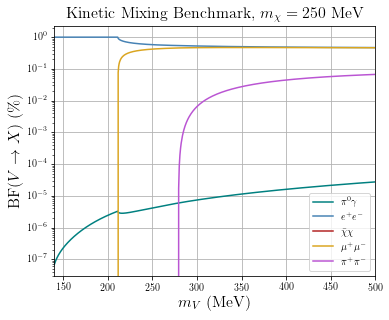

In [41]:
plt.figure(figsize=(latex_text_width_1col, 0.8*latex_text_width_1col))

km_params = {"mx": 250., "mv":500., "gvxx":1., "eps":1e-3}
km = KineticMixing(**km_params)

# Get branching fractions
bfs_raw = []
for mv in mvs:
    km.mv = mv
    bfs_raw.append(km.partial_widths())

bfs = {fs: [bf[fs] / bf["total"] for bf in bfs_raw] for fs in v_decay_fss}

for fs, bf_list in bfs.iteritems():
    lab = get_tex_label(fs)
    plt.plot(mvs, bf_list, color=get_color(fs), label=lab)

plt.xlim(mvs[[0, -1]])
plt.yscale("log")
plt.title(r"Kinetic Mixing Benchmark, $m_{\chi} = 250$ MeV", fontsize=16)
plt.grid()



plt.ylabel(r"BF($V\to X$) (\%)", fontsize=16)
plt.xlabel(r"$m_V$ (MeV)", fontsize=16)

plt.legend()
#title = plt.suptitle("Vector decay branching fractions")

### Quarks Only

In [3]:
qo_params = {"mx": 250., "mv":500., "gvxx":1., "gvuu" : 1., "gvdd" : 1., "gvss": 0.}
qo = QuarksOnly(**qo_params)

In [7]:
coupling_list = [{"gvuu": 1., "gvdd": 0.},
                 {"gvuu": 1., "gvdd": 1.},
                 {"gvuu": 0., "gvdd": 1.},
                 {"gvuu": 1., "gvdd": -1.}]

qo_params = {"mx": 250., "mv":500., "gvxx":1., "gvuu" : 1., "gvdd" : 1., "gvss": 0.}
qo = QuarksOnly(**qo_params)

v_decay_fss = (set(qo.list_final_states()) - set(['v v'])) | set(['x x'])

mvs = np.logspace(np.log10(140), np.log10(500), 500)

In [12]:
#plt.figure(figsize=(latex_text_width_1col, 0.8*latex_text_width_1col))
plt.figure(figsize=(6, 6))

for i, couplings in enumerate(coupling_list):
    plt.subplot(2, 2, i+1)
    gvuu = couplings["gvuu"]
    gvdd = couplings["gvdd"]
    
    qo.gvuu = gvuu
    qo.gvdd = gvdd
    
    # Get branching fractions
    bfs_raw = []
    for mv in mvs:
        qo.mv = mv
        bfs_raw.append(qo.partial_widths())

    bfs = {fs: [bf[fs] / bf["total"] for bf in bfs_raw] for fs in v_decay_fss}
    
    for fs, bf_list in bfs.iteritems():
        if fs in ["pi0 g", "pi pi", "x x"]:
            plt.plot(mvs, bf_list, color=get_color(fs), label=get_tex_label(fs))
        
    plt.xlim(mvs[[0, -1]])
    plt.yscale("log")
    plt.text(150, 1e-1, r"$g_{Vu} = %i$" % gvuu, fontsize=10)
    plt.text(150, 3e-2, r"$g_{Vd} = %i$" % gvdd, fontsize=10)
    plt.grid()
    
    if i == 1:
        plt.legend()
    if i in [1, 3]:
        plt.tick_params(labelleft="off")
    if i in [0, 2]:
        plt.ylabel("Branching fraction (\%)")
    if i in [0, 1]:
        plt.tick_params(labelbottom="off")
    if i in [2, 3]:
        plt.xlabel(r"$m_V$ (MeV)")
        
plt.suptitle("Vector decay branching fractions")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#plt.savefig("figures/vector_decay_branching_fractions.pdf")

ValueError: Image size of 424x283807 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x432 with 4 Axes>